In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
import numpy.ma as ma
from astropy.io import fits
from PIL import Image, ImageDraw

import src.astrocal.master as ac
import src.astrocal.reduction as re
import src.astrocal.astrometry as am
import src.astrocal.photometry as pt

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [2]:
main = "P:/Aurélien/Astronomie/Astrophoto"
target = "01-Ciel profond/M3_2024-03-06_RC6_ASI1600MM_LRGB/M 3"
filter = "LIGHT-L"

In [3]:
with fits.open(glob.glob(f"{main}/{target}/{filter}/*.fits")[0]) as hdul:
    hdu = hdul[0]
    exptime = hdu.header['EXPTIME']
    camera = hdu.header['INSTRUME']
    set_temp = hdu.header['SET-TEMP']

print(f"Camera : {camera}")
print(f"Exposure : {exptime:.2f}s")
print(f"Set temperature : {set_temp:.0f}°C")

Camera : ZWO ASI1600MM Pro
Exposure : 20.00s
Set temperature : -20°C


## Master frames

In [33]:
savedir_dark = f"{main}/{target}/DARK/MASTER"
# savedir_flat = f"{main}/FLAT/MASTER"
savedir_mask = f"{main}/{target}/MASK"

In [34]:
dark_filename = f"{main}/00-Calibration/DARK/{camera}/{set_temp:.0f}C/{exptime:.2f}s/*.fits"
master_dark, mask_hot = ac.make_master_dark(dark_filename, gen_hot_px=True, threshold=3, clean_bad_px=False, verbose=True)

Loading dark frames
Frame : 1/11
Frame : 2/11
Frame : 3/11
Frame : 4/11
Frame : 5/11
Frame : 6/11
Frame : 7/11
Frame : 8/11
Frame : 9/11
Frame : 10/11
Frame : 11/11
Generating master dark
Detecting hot pixels
Number of pixels in the frame  : 16389120
Number of hot pixels           :       70
Fraction of hot pixels (%)     : 0.00


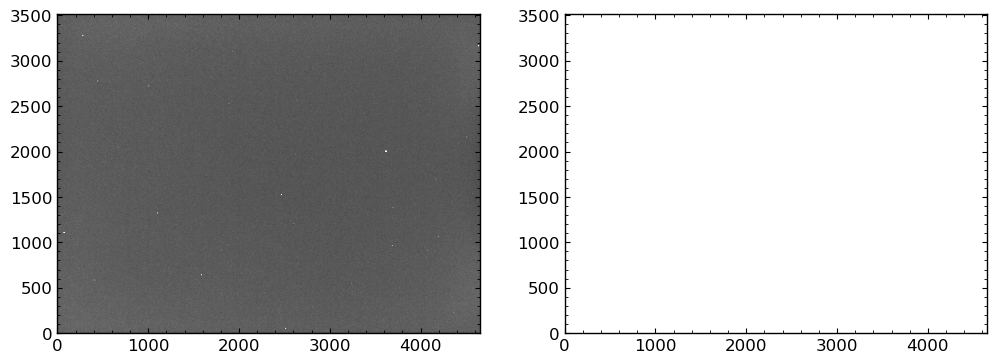

In [35]:
fig, axs = plt.subplots(1,2,figsize=(12,12))
norm = ImageNormalize(master_dark.data, interval=ZScaleInterval())
axs[0].imshow(master_dark.data, cmap='gray', origin='lower', norm=norm)
axs[1].imshow(mask_hot, cmap='gray_r', origin='lower', vmin=0, vmax=1)
plt.show()

In [36]:
dark_sample = glob.glob(dark_filename)[0].replace('\\','/')
ac.save_master(savedir_dark, master_dark, dark_sample, out_name=None)
ac.save_mask(savedir_mask, mask_hot, dark_sample, out_name=None)

In [ ]:
flat_filename = f"{main}/FLAT/SDSSgp+/FLAT*"
master_flat, mask_dead = ac.make_master_flat(flat_filename, threshold=0.5, gen_dead_px=True, clean_bad_px=False, mask=mask_hot, verbose=True)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,12))
norm = ImageNormalize(master_flat.data, interval=ZScaleInterval())
axs[0].imshow(master_flat.data, cmap='gray', origin='lower', norm=norm)
axs[1].imshow(mask_dead, cmap='gray_r', origin='lower', vmin=0, vmax=1)
plt.show()

In [ ]:
flat_sample = glob.glob(flat_filename)[0].replace('\\','/')
ac.save_master(savedir_flat, master_flat, flat_sample, out_name=None)
ac.save_mask(savedir_mask, mask_dead, flat_sample, out_name=None)

## Image reduction

In [4]:
generic_filename = f"{main}/{target}/{filter}/*.fits"
savedir = f"{main}/{target}/{filter}/REDUCED"

# DARK
master_dark_name = glob.glob(f"{main}/{target}/DARK/MASTER/*{exptime:.2f}s*.fits")[0]
master_dark = fits.open(master_dark_name)[0].data

# FLAT
# master_flat_name = glob.glob(f"{main}/FLAT/MASTER/*{filter}*")[0]
# master_flat = fits.open(master_flat_name)[0].data
master_flat = 1

# MASK
mask_dark_name = glob.glob(f"{main}/{target}/MASK/*.fits")[0]
mask_dark = fits.open(mask_dark_name)[0].data.astype(bool)
# mask_flat_name = glob.glob(f"{main}/MASK/*FLAT*{filter}*")[0]
# mask_flat = fits.open(mask_flat_name)[0].data.astype(bool)
mask_flat = False

Reducing science image


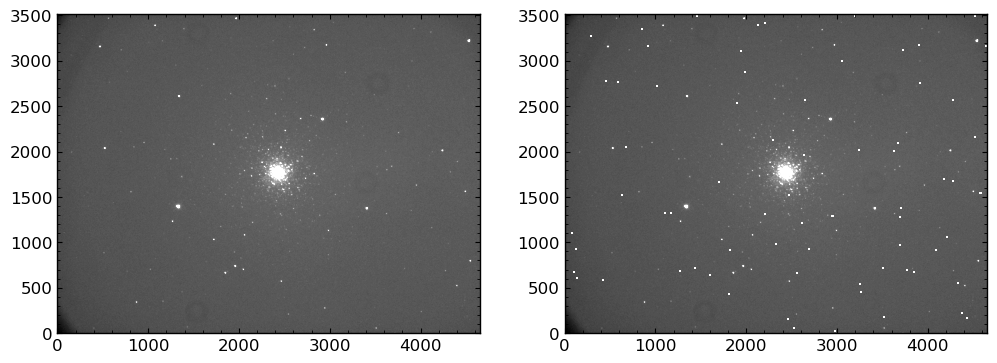

In [15]:
raw = fits.open(glob.glob(generic_filename)[0])[0]
reduced = re.reduce_one(glob.glob(generic_filename)[0], master_dark, master_flat, 
                        mask=np.logical_or(mask_dark, mask_flat),
                        verbose=True)

fig, axs = plt.subplots(1,2,figsize=(12,12))
norm = ImageNormalize(raw.data, interval=ZScaleInterval())
axs[0].imshow(raw.data, cmap='gray', origin='lower', norm=norm)
norm = ImageNormalize(reduced.data, interval=ZScaleInterval())
axs[1].imshow(reduced.data, cmap='gray', origin='lower', norm=norm)
plt.show()

In [16]:
re.reduce(generic_filename, savedir, master_dark_name, master_flat_name=None, mask_name=[mask_dark_name], verbose=True)

Loading master dark
Loading master flat
Loading mask(s)
Finding frames
---------------------------
Frame :   1/182
Reducing frame
Saving frame
---------------------------
Frame :   2/182
Reducing frame
Saving frame
---------------------------
Frame :   3/182
Reducing frame
Saving frame
---------------------------
Frame :   4/182
Reducing frame
Saving frame
---------------------------
Frame :   5/182
Reducing frame
Saving frame
---------------------------
Frame :   6/182
Reducing frame
Saving frame
---------------------------
Frame :   7/182
Reducing frame
Saving frame
---------------------------
Frame :   8/182
Reducing frame
Saving frame
---------------------------
Frame :   9/182
Reducing frame
Saving frame
---------------------------
Frame :  10/182
Reducing frame
Saving frame
---------------------------
Frame :  11/182
Reducing frame
Saving frame
---------------------------
Frame :  12/182
Reducing frame
Saving frame
---------------------------
Frame :  13/182
Reducing frame
Saving

## Astrometric calibration (plate-solving)

In [6]:
filter = "LIGHT-L"

generic_filename = f"{main}/{target}/{filter}/REDUCED/*.fits"
savedir = f"{main}/{target}/{filter}/REDUCED"

hdu = fits.open(glob.glob(generic_filename)[0])[0]
h, w = hdu.data.shape
mask = Image.new(mode="1", size=(w,h))
draw = ImageDraw.Draw(mask)
draw.circle((w/2, h/2), 800, fill=1)

am.astrometry_all(generic_filename, savedir, overwrite=False, mask_name=[mask_dark_name], mask=mask, first=0, threshold=7, fwhm=6, verbose=True)

Loading mask(s)
Finding frames
---------------------------
Frame :   1/182
Finding sources
Sources found : 54
Plate-solving
Solving.......FWHM : 4.55"
Pixel scale : 0.57"/px
Saving image with updated WCS
---------------------------
Frame :   2/182
Finding sources
Sources found : 24
Plate-solving
Solving........FWHM : 6.07"
Pixel scale : 0.57"/px
Saving image with updated WCS
---------------------------
Frame :   3/182
Finding sources
Sources found : 62
Plate-solving
Solving..........FWHM : 4.38"
Pixel scale : 0.57"/px
Saving image with updated WCS
---------------------------
Frame :   4/182
Finding sources
Sources found : 66
Plate-solving
Solving.......FWHM : 4.52"
Pixel scale : 0.57"/px
Saving image with updated WCS
---------------------------
Frame :   5/182
Finding sources
Sources found : 51
Plate-solving
Solving........FWHM : 4.45"
Pixel scale : 0.57"/px
Saving image with updated WCS
---------------------------
Frame :   6/182
Finding sources
Sources found : 60
Plate-solving
Solvin

AttributeError: 'NoneType' object has no attribute 'to_header'

## Photometric calibration

In [ ]:
date = "20240531"
filter = "SDSSgp+"

mask_dark = glob.glob(f"{main}/MASK/*DARK*")[0]
mask_flat = glob.glob(f"{main}/MASK/*FLAT*{filter}*")[0]
mask_name=[mask_dark, mask_flat]

generic_filename = f"{main}/LIGHT/{date}/{filter}/REDUCED/*.fits"

savedir = f"{main}/LIGHT/{date}/{filter}/PHOTOMETRY"

pt.photometry_all(generic_filename, savedir, mask_name,
                  calib_mag_col=f"{filter[-3]}mag", calib_emag_col=f"e_{filter[-3]}mag", 
                  plot=False, verbose=True)

In [ ]:
date = "20240531"
filter = "SDSSrp+"

mask_dark = glob.glob(f"{main}/MASK/*DARK*")[0]
mask_flat = glob.glob(f"{main}/MASK/*FLAT*{filter}*")[0]
mask_name=[mask_dark, mask_flat]

generic_filename = f"{main}/LIGHT/{date}/{filter}/REDUCED/*.fits"

savedir = f"{main}/LIGHT/{date}/{filter}/PHOTOMETRY"

pt.photometry_all(generic_filename, savedir, mask_name, first=0,
                  detect_fwhm=8, detect_threshold=5,
                  calib_mag_col=f"{filter[-3]}mag", calib_emag_col=f"e_{filter[-3]}mag", 
                  plot=False, verbose=True)

In [ ]:
date = "20240531"
filter = "SDSSip+"

mask_dark = glob.glob(f"{main}/MASK/*DARK*")[0]
mask_flat = glob.glob(f"{main}/MASK/*FLAT*{filter}*")[0]
mask_name=[mask_dark, mask_flat]

generic_filename = f"{main}/LIGHT/{date}/{filter}/REDUCED/*.fits"

savedir = f"{main}/LIGHT/{date}/{filter}/PHOTOMETRY"

pt.photometry_all(generic_filename, savedir, mask_name,
                  detect_fwhm=8, detect_threshold=5,
                  calib_mag_col=f"{filter[-3]}mag", calib_emag_col=f"e_{filter[-3]}mag", 
                  plot=False, verbose=True)